In [64]:
import json
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 8)
plt.style.use(['ggplot'])

import os
from dtw import dtw
import pandas as pd
import pickle


cwd = os.getcwd()
print (cwd)
# import mlpy

Populating the interactive namespace from numpy and matplotlib
/accounts/grad/jorothy_gong/MyShakeAnalysis/code/Yun


In [26]:
import random
from obspy.signal.trigger import classic_sta_lta
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [27]:
def get_data(data):
    '''
    helper function to get the timestamp and 3-component acceleration data. 
    '''
    # read in x, y, z data
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = [t0 + tmp/sampling_rate for tmp in range(0, npoints)]
    
    # station latitude and long
    return t, x, y, z

def plot_data(t, x, y, z):
    '''
    helper function to plot the 3-component acceleration data
    '''
    figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(311)
    plt.plot(t, x)
    plt.subplot(312)
    plt.plot(t, y)
    plt.ylabel('Acceleration (g)')
    plt.subplot(313)
    plt.plot(t, z)
    plt.xlabel('Time (sec)')
    plt.show()

## Read simulated data

7500 7500 25.0


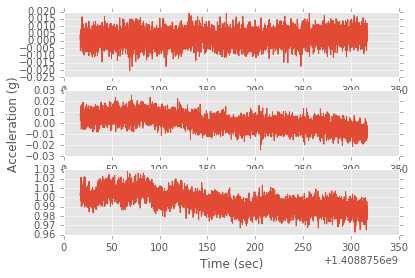

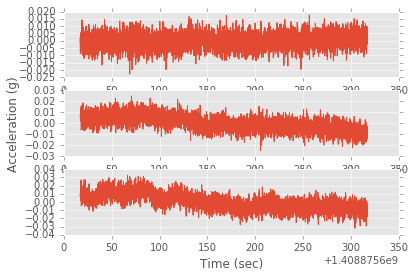

In [28]:
data = json.load(open('../../data/EQ/simulated/J045_M6.0_1408875617.json', 'r'))

t, x, y, z = get_data(data)
rate = data['header']['sampling_rate'];
#print(data['header'])
print (len(x), len(t), rate)
plot_data(t, x, y, z)

x, y, z = Normalize_Seq(x, y, z)
plot_data(t, x, y, z)

## Read shake table data

984 984 25.0


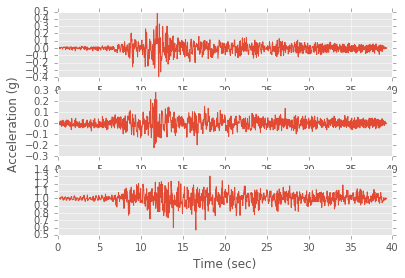

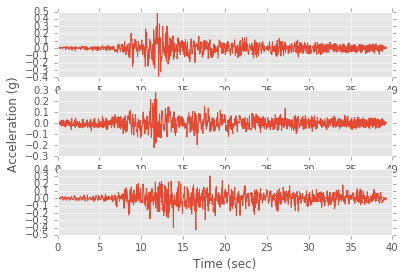

In [29]:
data = json.load(open('../../data/EQ/shake_table/trial142_phone2.json', 'r'))

t, x, y, z = get_data(data)
rate = data['header']['sampling_rate'];
print (len(x), len(t), rate)
plot_data(t, x, y, z)
# from matplotlib.pyplot import specgram
# specgram(z, NFFT=100, Fs=rate, noverlap = 50);

x, y, z = Normalize_Seq(x, y, z)
plot_data(t, x, y, z)

## Read human data

6284 6284 25.0


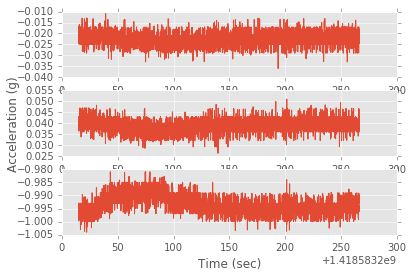

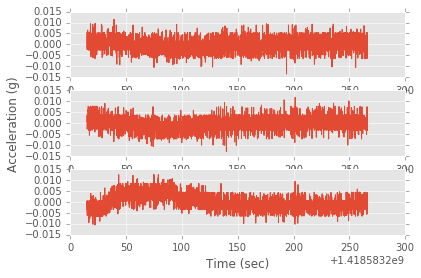

In [30]:
data = json.load(open('../../data/Human/013306004148017_1418583215.json', 'r'))

t, x, y, z = get_data(data)
rate = data['header']['sampling_rate'];
print (len(x), len(t), rate)
plot_data(t, x, y, z)

x, y, z = Normalize_Seq(x, y, z)
plot_data(t, x, y, z)

## Dynamic Time Warping

In [31]:
def Normalize_Seq(seq_x = None, seq_y = None, seq_z = None, dim = 3):
    """
    May need further normalization later.
    Take either 1-dim accelaretion sequence or 3-dim, or 2-idm.
    """
    tmp = []
    if seq_x != None:
        seq_x = seq_x - np.mean(seq_x)
        tmp.append(seq_x)
    if seq_y != None:
        seq_y = seq_y - np.mean(seq_y)
        tmp.append(seq_y)
    if seq_z != None:
        seq_z = seq_z - np.mean(seq_z)
        tmp.append(seq_z)
        
    if dim != 3:
        return tmp
    else:
        return seq_x, seq_y, seq_z

In [32]:
def MyDistance(x, y):
    return (x * x) + (y * y)

def Cal_DTW(x, y, fun = None):
    #print('ha')
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    if fun == None:
        dist, cost, acc, path = dtw(x, y, dist = lambda x, y: norm(x - y, ord=1))
    else:
        dist, cost, acc, path = dtw(x, y, dist = fun)
        
    return dist

In [33]:
# Cal_DTW_Compare
def DTW_Self(seq, window = 2, interval = 0.5, gap = 1/5, rate = 25):
    """
    Now sequence is only 1-dim accelaration sequence.
    Add if sequence length < 5 seconds
    """
    seq = seq - np.mean(seq)
    seq_len = len(seq)
    seq_win = int(window * rate)
    seq_int = int(interval * rate)
    compute_gap = int(gap * rate)
    return [Cal_DTW(seq[i : (i + seq_win)], seq[(i + seq_int) : (i + seq_win + seq_int)]) 
            for i in range(0, seq_len - seq_win - seq_int, compute_gap)]
 

In [34]:
path_to_json = cwd + '/../../data/EQ/shake_table/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files = json_files

192


In [31]:
DTW = {}

for js in json_files:
    print(js)
    with open(path_to_json+js) as infile:
        data = json.load(infile)
      
    t, x, y, z = get_data(data)
    rate = data['header']['sampling_rate']
    x, y, z = Normalize_Seq(x, y, z)
    DTW[js] = {'DTW_x': DTW_Self(seq = x, rate = rate), 
                     'DTW_y': DTW_Self(seq = y, rate = rate), 
                     'DTW_z': DTW_Self(seq = z, rate = rate)}
    
with open(path_to_json + 'DTW_shake.json', 'w') as f:
    json.dump(DTW, f, indent=None, sort_keys=False)

trial38_phone4.json
trial165_phone1.json
trial143_phone0.json
trial21_phone1.json
trial62_phone3.json
trial155_phone5.json
trial144_phone3.json
trial162_phone2.json
trial65_phone0.json
trial63_phone5.json
trial45_phone4.json
trial39_phone2.json
trial153_phone0.json
trial27_phone4.json
trial145_phone5.json
trial163_phone4.json
trial65_phone4.json
trial38_phone0.json
trial143_phone4.json
trial165_phone5.json
trial155_phone1.json
trial21_phone5.json
trial27_phone0.json
trial64_phone2.json
trial153_phone4.json
trial163_phone0.json
trial145_phone1.json
trial45_phone0.json
trial20_phone3.json
trial63_phone1.json
trial142_phone2.json
trial164_phone3.json
trial156_phone3.json
trial61_phone5.json
trial151_phone0.json
trial148_phone5.json
trial33_phone1.json
trial147_phone5.json
trial146_phone3.json
trial67_phone0.json
trial40_phone3.json
trial151_phone4.json
trial66_phone2.json
trial148_phone1.json
trial147_phone1.json
trial33_phone5.json
trial61_phone1.json
trial166_phone3.json
trial150_phone2

## Visualize Features

In [35]:
with open(cwd + '/DTW_shake.json') as infile:
    DTW_shake = json.load(infile)
    
with open(cwd + '/DTW_human.json') as infile:
    DTW_human = json.load(infile)
    
with open(cwd + '/DTW_simulated.json') as infile:
    DTW_simulated = json.load(infile)

In [36]:
# each: list of list of DTW trend
DTW_shake_x = [DTW_shake[i]['DTW_x'] for i in DTW_shake.keys()]
DTW_human_x = [DTW_human[i]['DTW_x'] for i in DTW_human.keys()]
DTW_simulated_x = [DTW_simulated[i]['DTW_x'] for i in DTW_simulated.keys()]

DTW_shake_y = [DTW_shake[i]['DTW_y'] for i in DTW_shake.keys()]
DTW_human_y = [DTW_human[i]['DTW_y'] for i in DTW_human.keys()]
DTW_simulated_y = [DTW_simulated[i]['DTW_y'] for i in DTW_simulated.keys()]

DTW_shake_z = [DTW_shake[i]['DTW_z'] for i in DTW_shake.keys()]
DTW_human_z = [DTW_human[i]['DTW_z'] for i in DTW_human.keys()]
DTW_simulated_z = [DTW_simulated[i]['DTW_z'] for i in DTW_simulated.keys()]

In [37]:
pd.DataFrame({'a' : [len(DTW_shake_x[i]) for i in range(100)],
             'b' : [len(DTW_human_x[i]) for i in range(100)],
             'c' : [len(DTW_simulated_x[i]) for i in range(100)]})

,a,b,c
0,182,91,883
1,180,288,238
2,204,288,1501
3,173,288,1488
4,109,288,1488
5,180,288,188
6,231,288,346
7,173,288,363
8,192,288,313
9,156,288,343


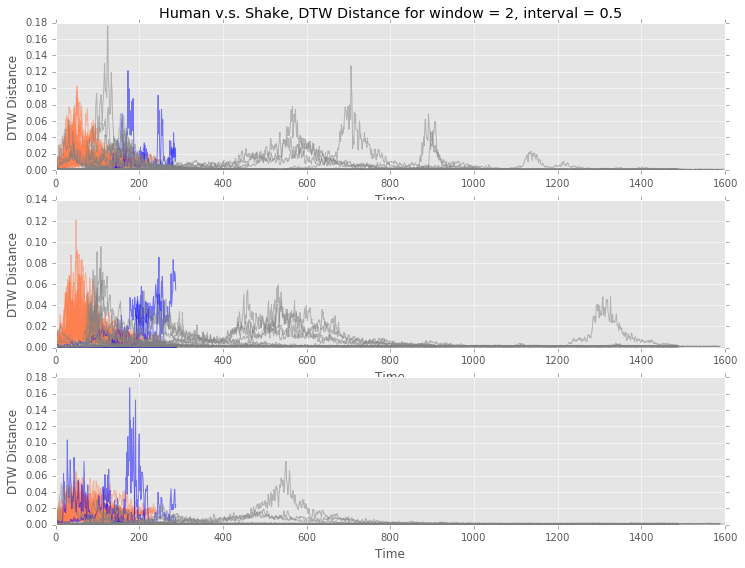

In [42]:
#plt.style.use(['dark_background'])
plt.style.use(['ggplot'])

figure(num=None, figsize=(12, 9), dpi=80)

plt.subplot(311)
[plt.plot(DTW_shake_x[i], color='coral', alpha=0.5) for i in random.sample(range(len(DTW_shake_x)),50)]
[plt.plot(DTW_human_x[i], color='blue', alpha=0.5) for i in random.sample(range(len(DTW_human_x)),50)]
[plt.plot(DTW_simulated_x[i], color='grey', alpha=0.5) for i in random.sample(range(len(DTW_simulated_x)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')
plt.title('Human v.s. Shake, DTW Distance for window = 2, interval = 0.5')

plt.subplot(312)
[plt.plot(DTW_shake_y[i], color='coral', alpha=0.5) for i in random.sample(range(len(DTW_shake_y)),50)]
[plt.plot(DTW_human_y[i], color='blue', alpha=0.5) for i in random.sample(range(len(DTW_human_y)),50)]
[plt.plot(DTW_simulated_y[i], color='grey', alpha=0.5) for i in random.sample(range(len(DTW_simulated_y)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')

plt.subplot(313)
[plt.plot(DTW_shake_z[i], color='coral', alpha=0.5) for i in random.sample(range(len(DTW_shake_z)),50)]
[plt.plot(DTW_human_z[i], color='blue', alpha=0.5) for i in random.sample(range(len(DTW_human_z)),50)]
[plt.plot(DTW_simulated_z[i], color='grey', alpha=0.5) for i in random.sample(range(len(DTW_simulated_z)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')

#fig.suptitle('DTW of x,y,z: shake(color) v.s. human(grey)', fontsize=12)
plt.show()

In [159]:
# radius = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
# area = [3.14159, 12.56636, 28.27431, 50.26544, 78.53975, 113.09724]
# square = [1.0, 4.0, 9.0, 16.0, 25.0, 36.0]
# plt.plot(radius, area, label='Circle')
# plt.plot(radius, square, marker='o', linestyle='--', random.sample(range(len(DTW_shake_x)),30), label='Square')
# plt.xlabel('Radius/Side')
# plt.ylabel('Area')
# plt.title('Area of Shapes')
# plt.legend()
# plt.show()

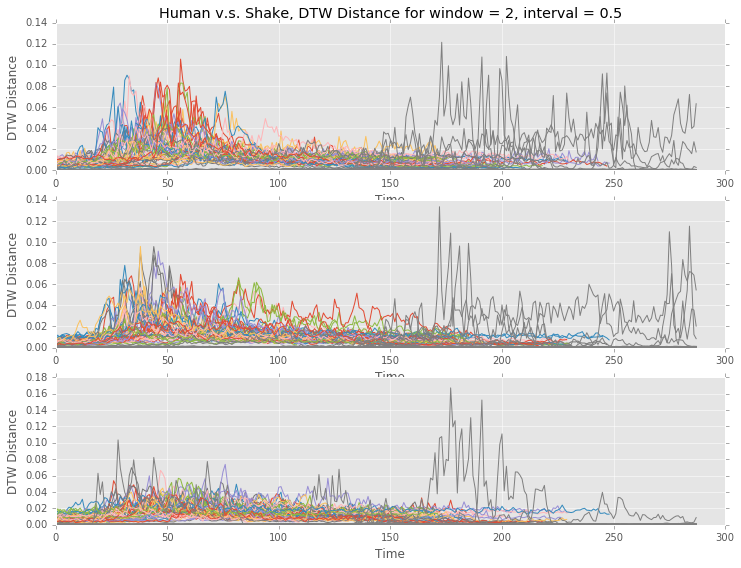

In [44]:
#plt.style.use(['dark_background'])
plt.style.use(['ggplot'])

figure(num=None, figsize=(12, 9), dpi=80)

plt.subplot(311)
[plt.plot(DTW_shake_x[i]) for i in random.sample(range(len(DTW_shake_x)),50)]
[plt.plot(DTW_human_x[i], color='grey') for i in random.sample(range(len(DTW_human_x)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')
plt.title('Human v.s. Shake, DTW Distance for window = 2, interval = 0.5')

plt.subplot(312)
[plt.plot(DTW_shake_y[i]) for i in random.sample(range(len(DTW_shake_y)),50)]
[plt.plot(DTW_human_y[i], color='grey') for i in random.sample(range(len(DTW_human_y)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')

plt.subplot(313)
[plt.plot(DTW_shake_z[i]) for i in random.sample(range(len(DTW_shake_z)),50)]
[plt.plot(DTW_human_z[i], color='grey') for i in random.sample(range(len(DTW_human_z)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')

#fig.suptitle('DTW of x,y,z: shake(color) v.s. human(grey)', fontsize=12)
plt.show()

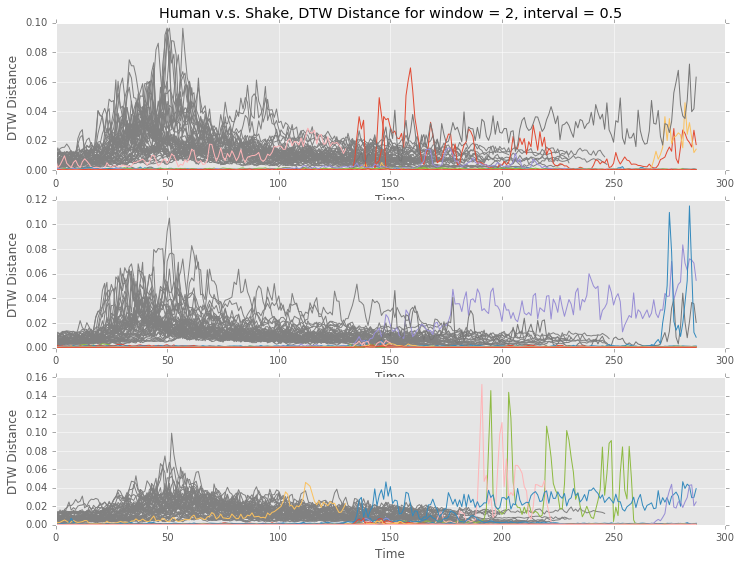

In [45]:
#plt.style.use(['dark_background'])
plt.style.use(['ggplot'])

figure(num=None, figsize=(12, 9), dpi=80)

plt.subplot(311)
[plt.plot(DTW_shake_x[i], color='grey') for i in random.sample(range(len(DTW_shake_x)),50)]
[plt.plot(DTW_human_x[i]) for i in random.sample(range(len(DTW_human_x)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')
plt.title('Human v.s. Shake, DTW Distance for window = 2, interval = 0.5')


plt.subplot(312)
[plt.plot(DTW_shake_y[i], color='grey') for i in random.sample(range(len(DTW_shake_y)),50)]
[plt.plot(DTW_human_y[i]) for i in random.sample(range(len(DTW_human_y)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')

plt.subplot(313)
[plt.plot(DTW_shake_z[i], color='grey') for i in random.sample(range(len(DTW_shake_z)),50)]
[plt.plot(DTW_human_z[i]) for i in random.sample(range(len(DTW_human_z)),50)]
plt.xlabel('Time')
plt.ylabel('DTW Distance')

#fig.suptitle('DTW of x,y,z: shake(grey) v.s. human(color)', fontsize=12)
plt.show()

[[<matplotlib.lines.Line2D at 0x7effc8519748>],

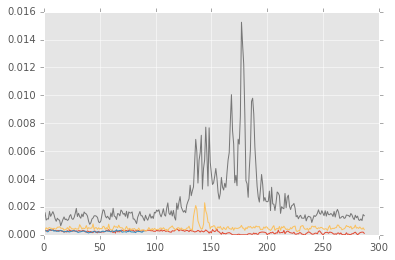

In [47]:
[plt.plot(DTW_human_z[i]) for i in random.sample(range(len(DTW_human_z)),5)]


In [279]:
DTW_human['990002035238946_1424356719.json']

{'DTW_x': [], 'DTW_y': [], 'DTW_z': []}

In [274]:
[len(DTW_human_z[i]) for i in range(100)]

[288,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 0,
 288,
 288,
 0,
 0,
 0,
 288,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 288,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 288,
 288,
 0,
 288,
 288,
 0,
 91,
 0,
 0,
 0,
 288,
 288,
 0,
 288,
 0,
 288,
 288,
 288,
 0,
 288,
 0,
 288,
 288,
 288,
 0,
 288,
 0,
 288,
 288,
 288,
 288,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 0,
 0,
 288,
 288,
 0,
 288,
 288,
 288,
 288,
 288,
 131,
 288,
 0,
 288]

In [280]:
feature_DTW = [list(zip(np.round(DTW_shake_x[i],6), np.round(DTW_shake_y[i],6) , np.round(DTW_shake_z[i],6))) 
 for i in range(len(DTW_shake_x))]

## Aggregate Data for Random Forest

In [48]:
# Cal_DTW_Compare
def DTW_Self(seq, window = 2, interval = 1, gap = 1, rate = 25):
    """
    Now sequence is only 1-dim accelaration sequence.
    Add if sequence length < 5 seconds
    """
    seq = seq - np.mean(seq)
    seq_len = len(seq)
    seq_win = int(window * rate)
    seq_int = int(interval * rate)
    compute_gap = int(gap * rate)
    return [Cal_DTW(seq[i : (i + seq_win)], seq[(i + seq_int) : (i + seq_win + seq_int)]) 
            for i in range(0, seq_len - seq_win - seq_int, compute_gap)]
 

In [49]:
from obspy.signal.trigger import classic_sta_lta
# from obspy.signal.trigger import z_detect
# cft = z_detect(x, int(10 * rate))
# from obspy.signal.trigger import plot_trigger

data = json.load(open('../../data/EQ/simulated/FHO_M5.1_1396066187.json', 'r'))


def get_data2(data, group = 'simulated', plot_trigger = False,
              window = 2, interval = 1, gap = 1, rate = 25, threshold_sta_lta = 1.5):
    """
    1.How to define trigger in the sta_lta need to be discussed, the threshold = 1.5 may not be good for Human, 
    though sounds plausible. involve variance median mean? tuning short/long time as 2/10 seconds
    2.thus in future aggregating data may be different for human and EQ
    3.when design features in the future, window and gap here can be set coincide with the windows used in features
    """
    if group == 'simulated':
        t, x, y, z = get_data(data)
        rate = data['header']['sampling_rate']
        x, y, z = Normalize_Seq(x, y, z)
        #print(len(x),len(y),len(z),len(t),rate)
        length = min(len(x),len(y),len(z),len(t))
        ## window, gap
        predictor = [[x[i],y[i],z[i]] for i in range(length)]
        cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
        cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
        cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
        response = ((cft_x > threshold_sta_lta)*1 * (cft_y > threshold_sta_lta)*1 * (cft_z > threshold_sta_lta)*1)

    elif group == 'shake_table':
        t, x, y, z = get_data(data)
        rate = data['header']['sampling_rate']
        x, y, z = Normalize_Seq(x, y, z)
        #print(len(x),len(y),len(z),len(t),rate)
        length = min(len(x),len(y),len(z),len(t))
        ## window gap
        predictor = [[x[i],y[i],z[i]] for i in range(length)]
        cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
        cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
        cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
        response = ((cft_x > threshold_sta_lta)*1 * (cft_y > threshold_sta_lta)*1 * (cft_z > threshold_sta_lta)*1)

    # [i/25 for i,x in enumerate(response) if x ==1]
    elif group == 'human':
        t, x, y, z = get_data(data)
        rate = data['header']['sampling_rate']
        x, y, z = Normalize_Seq(x, y, z)
        #print(len(x),len(y),len(z),len(t),rate)
        length = min(len(x),len(y),len(z),len(t))
        ## window gap
        predictor = [[x[i],y[i],z[i]] for i in range(length)]
        cft_x = classic_sta_lta(x[:length], int(2 * rate), int(10 * rate))
        cft_y = classic_sta_lta(y[:length], int(2 * rate), int(10 * rate))
        cft_z = classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))
        #response = ((cft_x > threshold_sta_lta)*1 * (cft_y > threshold_sta_lta)*1 * (cft_z > threshold_sta_lta)*1)
        response = [0 for i in range(length)]
        
    if plot_trigger:
        plot_data(t, x, y, z)
        plt.plot(cft_x)
        plt.plot(cft_y)
        plt.plot(cft_z)
        plt.axhline(y=threshold_sta_lta, color='black')
        
        
    return predictor, response
        
    

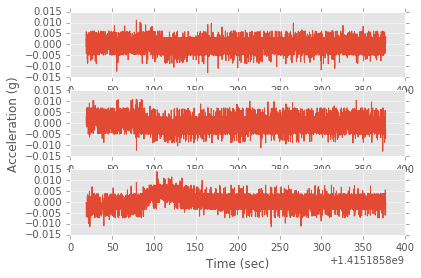

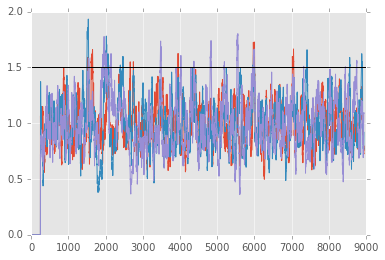

In [50]:
data = json.load(open('../../data/Human/013306004148017_1415185819.json', 'r'))
predictor, response = get_data2(data, group = 'human', plot_trigger=True)
# [i/25 for i,x in enumerate(response) if x ==1]

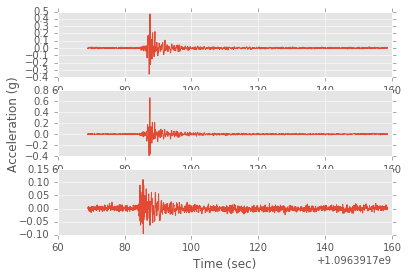

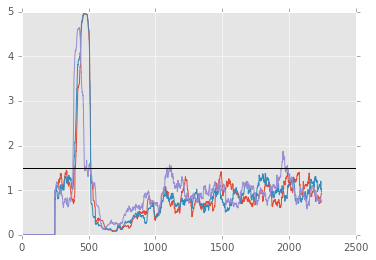

In [235]:
data = json.load(open('../../data/EQ/simulated/36668_M6.0_1096391769.json', 'r'))
predictor, response = get_data2(data, group = 'simulated', plot_trigger=True)

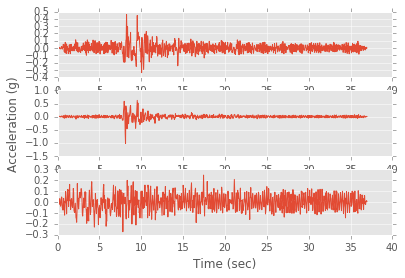

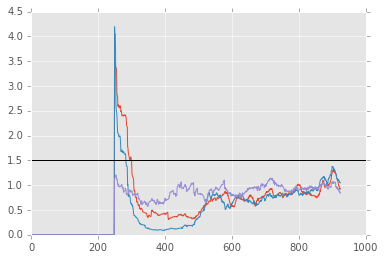

In [245]:
data = json.load(open('../../data/EQ/shake_table/trial61_phone1.json', 'r'))
predictor, response = get_data2(data, group = 'shake_table', plot_trigger=True)

In [247]:
data['header']

{'sampling_rate': 25.0,
 'starttime': 0.0,
 'station': 'phone1',
 'stla': 12345,
 'stlo': 12345,
 'triggertime': 12345}

In [53]:
path_to_json = cwd + '/../../data/EQ/shake_table/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files_shake = json_files

path_to_json = cwd + '/../../data/EQ/simulated/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files_simulated = json_files

path_to_json = cwd + '/../../data/Human/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(len(json_files))
json_files_human = json_files[:5000]

####
# json_files = json_files_shake + json_files_simulated + json_files_human
path_to_json = cwd + '/../../data/EQ/shake_table/'
json_files = json_files_shake

192
992
26343


In [54]:
X = []
Y = []

for js in json_files:
    print(js)
    with open(path_to_json+js) as infile:
        data = json.load(infile)
    
    predictor, response = get_data2(data, group = 'shake_table', plot_trigger=False)
    print(len(predictor) == len(response))
    X.extend(predictor)
    Y.extend(response)
    #Y = np.append(Y,response)
    
X = np.asarray(X)
Y = np.asarray(Y)

n_train = int(len(X)*0.5)
n_test = int(len(X)*0.4)

X_train = X[:n_train]
Y_train = Y[:n_train]

X_valid= X[n_train:-n_test]
Y_valid = Y[n_train:-n_test]

X_test = X[-n_test:]
Y_test = Y[-n_test:]
# with open(path_to_json + 'DTW_shake.json', 'w') as f:
#     json.dump(DTW, f, indent=None, sort_keys=False)

trial38_phone4.json
True
trial165_phone1.json
True
trial143_phone0.json
True
trial21_phone1.json
True
trial62_phone3.json
True
trial155_phone5.json
True
trial144_phone3.json
True
trial162_phone2.json
True
trial65_phone0.json
True
trial63_phone5.json
True
trial45_phone4.json
True
trial39_phone2.json
True
trial153_phone0.json
True
trial27_phone4.json
True
trial145_phone5.json
True
trial163_phone4.json
True
trial65_phone4.json
True
trial38_phone0.json
True
trial143_phone4.json
True
trial165_phone5.json
True
trial155_phone1.json
True
trial21_phone5.json
True
trial27_phone0.json
True
trial64_phone2.json
True
trial153_phone4.json
True
trial163_phone0.json
True
trial145_phone1.json
True
trial45_phone0.json
True
trial20_phone3.json
True
trial63_phone1.json
True
trial142_phone2.json
True
trial164_phone3.json
True
trial156_phone3.json
True
trial61_phone5.json
True
trial151_phone0.json
True
trial148_phone5.json
True
trial33_phone1.json
True
trial147_phone5.json
True
trial146_phone3.json
True
tria

In [55]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, Y_train)

clf_label = clf.predict(X_test)
precision_recall_fscore_support(Y_test,clf_label)



(array([ 0.9487136 ,  0.53901099]),
 array([ 0.98765959,  0.21275211]),
 array([ 0.96779494,  0.30508475]),
 array([67988,  4611]))

In [56]:
clf_probs = clf.predict_proba(X_test)
score = log_loss(Y_test, clf_probs)
score


0.52636335101485054

In [57]:
# Train random forest classifier, calibrate on validation data and evaluate on test data
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, Y_valid)

sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(Y_test, sig_clf_probs)
sig_score

0.18799776733996409

## Incorporate all : DTW, sta-lta, 

In [65]:
f1 = open('data1.pckl', 'rb')
f0 = open('data0.pckl', 'rb')
data1 = pickle.load(f1)
data0 = pickle.load(f0)
f1.close()
f0.close()


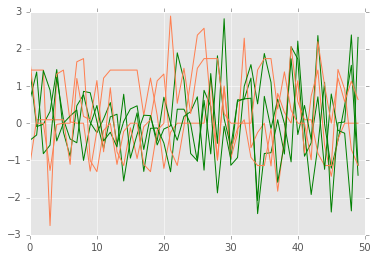

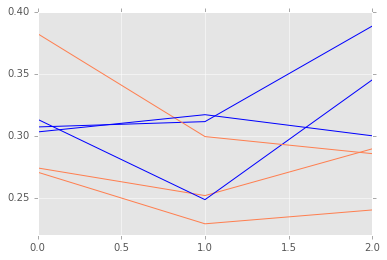

In [172]:
## Visualize DTW for x,y,z
row = 0
for i in np.linspace(0,100,3,dtype=int):
    plt.plot(data1[row,:-1][i:(i+50)], color = 'green')
    plt.plot(data0[row,:-1][i:(i+50)], color = 'coral')
plt.show()
    
for i in np.linspace(0,100,3,dtype=int):
    plt.plot(DTW_Self(seq = data1[row,:-1][i:(i+50)], 
                      window = 25/25, interval = 10/25, gap = 5/25, rate = 25), color = 'blue')
    plt.plot(DTW_Self(seq = data0[row,:-1][i:(i+50)], 
                      window = 25/25, interval = 10/25, gap = 5/25, rate = 25), color = 'coral')
plt.show()

In [ ]:
row = 0

In [175]:
for i in np.linspace(0,100,3,dtype=int):
    print(DTW_Self(seq = data1[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25))
    #DTW_Self(seq = data0[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25)

[0.30698776635598696, 0.31127580048710685, 0.38839435939516187]
[0.31315431949622818, 0.24834142544205853, 0.34503182268919685]
[0.30295017003444524, 0.31686284407690041, 0.29982140745885233]


In [192]:
a = np.array([DTW_Self(seq = data0[row,:-1][i:(i+50)], window = 25/25, interval = 10/25, gap = 5/25, rate = 25) 
              for i in np.linspace(0,100,3,dtype=int)]).ravel()

In [193]:
np.var(a)

0.0017861938955647274

In [233]:
pd.DataFrame(np.append(a,np.var(a)).reshape(1,-1))

,0,1,2,3,4,5,6,7,8,9
0,0.273925,0.251631,0.289367,0.382209,0.299213,0.285442,0.270514,0.228864,0.240048,0.001786


In [ ]:
classic_sta_lta(z[:length], int(2 * rate), int(10 * rate))

## Manifold Learning

In [248]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

In [249]:
# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

In [250]:
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

In [251]:
try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(251, projection='3d')
    plt.scatter(X[:, 0], X[:, 2], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

standard: 0.8 sec
ltsa: 0.26 sec
hessian: 0.37 sec
modified: 0.28 sec


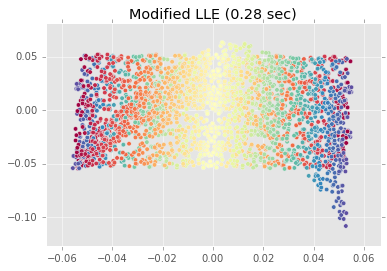

In [252]:
for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

SpectralEmbedding: 0.25 sec


(-0.19825944290329123,
 0.21065069757989308,
 -0.19918517969350261,
 0.22906261658882854)

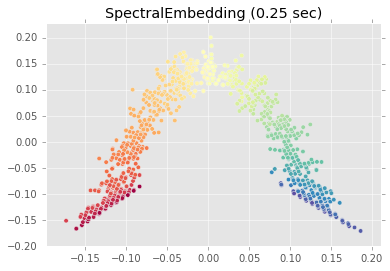

In [285]:
t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

In [293]:
[int(i<2000) for i in range(3728)]

0

SpectralEmbedding: 20 sec


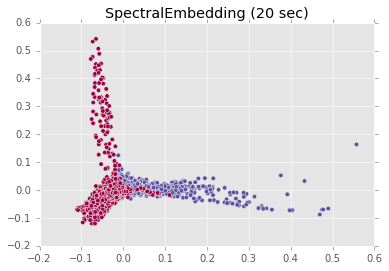

In [294]:
t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(np.append(data0[:2000,:-1],data1[:,:-1],axis=0))
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1],c=[int(i<2000) for i in range(3728)], cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))


Isomap: 12 sec


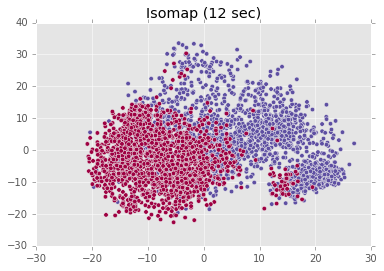

In [295]:
t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(np.append(data0[:2000,:-1],data1[:,:-1],axis=0))
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=[int(i<2000) for i in range(3728)], cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))

